# 04 - Report & Visualizations

This notebook creates visualizations for the LinkedIn article:
- Time series plot with forecast overlay (all models)
- Horizon-specific accuracy comparison (bar chart: MASE by model)
- Prediction interval calibration (coverage vs nominal)
- Model performance summary tables

Target: LinkedIn article showcasing foundation model performance on epidemiological surveillance data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

np.random.seed(42)

# Set style for publication-quality figures
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 9

## Load Data

In [2]:
project_root = Path.cwd().parent
data_dir = project_root / 'data'
results_dir = project_root / 'results'
forecasts_dir = results_dir / 'forecasts'
figures_dir = results_dir / 'figures'

figures_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# Load actual data
flu_series = pd.read_pickle(data_dir / 'flu_daily_clean.pkl')
print(f"Actual data: {len(flu_series)} observations from {flu_series.index.min().date()} to {flu_series.index.max().date()}")

Actual data: 1078 observations from 2022-07-04 to 2025-06-15


In [4]:
# Load all forecast files
forecast_files = list(forecasts_dir.glob('*.parquet'))
forecasts_list = []
for f in forecast_files:
    df = pd.read_parquet(f)
    forecasts_list.append(df)

forecasts_df = pd.concat(forecasts_list, ignore_index=True)
print(f"\nForecasts: {forecasts_df.shape[0]} rows")
print(f"Models: {', '.join(sorted(forecasts_df['model'].unique()))}")
print(f"Horizons: {sorted(forecasts_df['horizon'].unique())} days")


Forecasts: 188 rows
Models: Chronos_Tiny, LightGBM, SARIMA_Fourier, TabPFN_TS
Horizons: [7, 28] days


In [5]:
# Load summary metrics
summary_df = pd.read_csv(results_dir / 'summary.csv')
print("\nSummary metrics:")
print(summary_df.to_string(index=False))


Summary metrics:
         model  horizon  n_forecasts      MAPE     sMAPE     MASE     CRPS  Coverage_80
      LightGBM        7           24 18.649180 18.538976 0.286662 1.538541    50.000000
      LightGBM       28           23 68.831980 57.556026 0.985594 4.909233    26.086957
     TabPFN_TS        7           24 33.548724 39.186586 0.370339 2.227154    58.333333
     TabPFN_TS       28           23 46.271920 63.007671 0.872181 4.509701    60.869565
SARIMA_Fourier        7           24 65.177785 76.415992 1.006944 4.785015    41.666667
SARIMA_Fourier       28           23 69.948019 83.730633 1.170388 5.759718    47.826087
  Chronos_Tiny        7           24 15.096814 15.237444 0.219267 1.186668    66.666667
  Chronos_Tiny       28           23 47.997534 41.625952 0.766558 4.119184    69.565217


## Define Model Colors & Labels

In [6]:
# Consistent color scheme for all visualizations
model_colors = {
    'Chronos_Tiny': '#1f77b4',      # Blue - Foundation model
    'TabPFN_TS': '#ff7f0e',         # Orange - Foundation model
    'LightGBM': '#2ca02c',          # Green - ML model
    'SARIMA_Fourier': '#d62728'     # Red - Statistical baseline
}

model_labels = {
    'Chronos_Tiny': 'Chronos-Tiny (Foundation)',
    'TabPFN_TS': 'TabPFN-TS (Foundation)',
    'LightGBM': 'LightGBM (ML)',
    'SARIMA_Fourier': 'SARIMA+Fourier (Baseline)'
}

# Ordered list for consistent legend/chart ordering
model_order = ['Chronos_Tiny', 'TabPFN_TS', 'LightGBM', 'SARIMA_Fourier']

## Figure 1: Time Series with Forecast Overlay

Show actual data with sample forecasts from each model (7-day and 28-day horizons)

In [7]:
# Select a representative forecast origin for visualization
# Choose one from the middle of the testing period
all_origins = sorted(forecasts_df['origin'].unique())
viz_origin = all_origins[len(all_origins) // 3]  # Pick from first third

print(f"Visualization forecast origin: {viz_origin.date()}")
print(f"Available horizons: {sorted(forecasts_df['horizon'].unique())} days")

Visualization forecast origin: 2024-10-28
Available horizons: [7, 28] days


✅ Saved forecast_single_origin.png


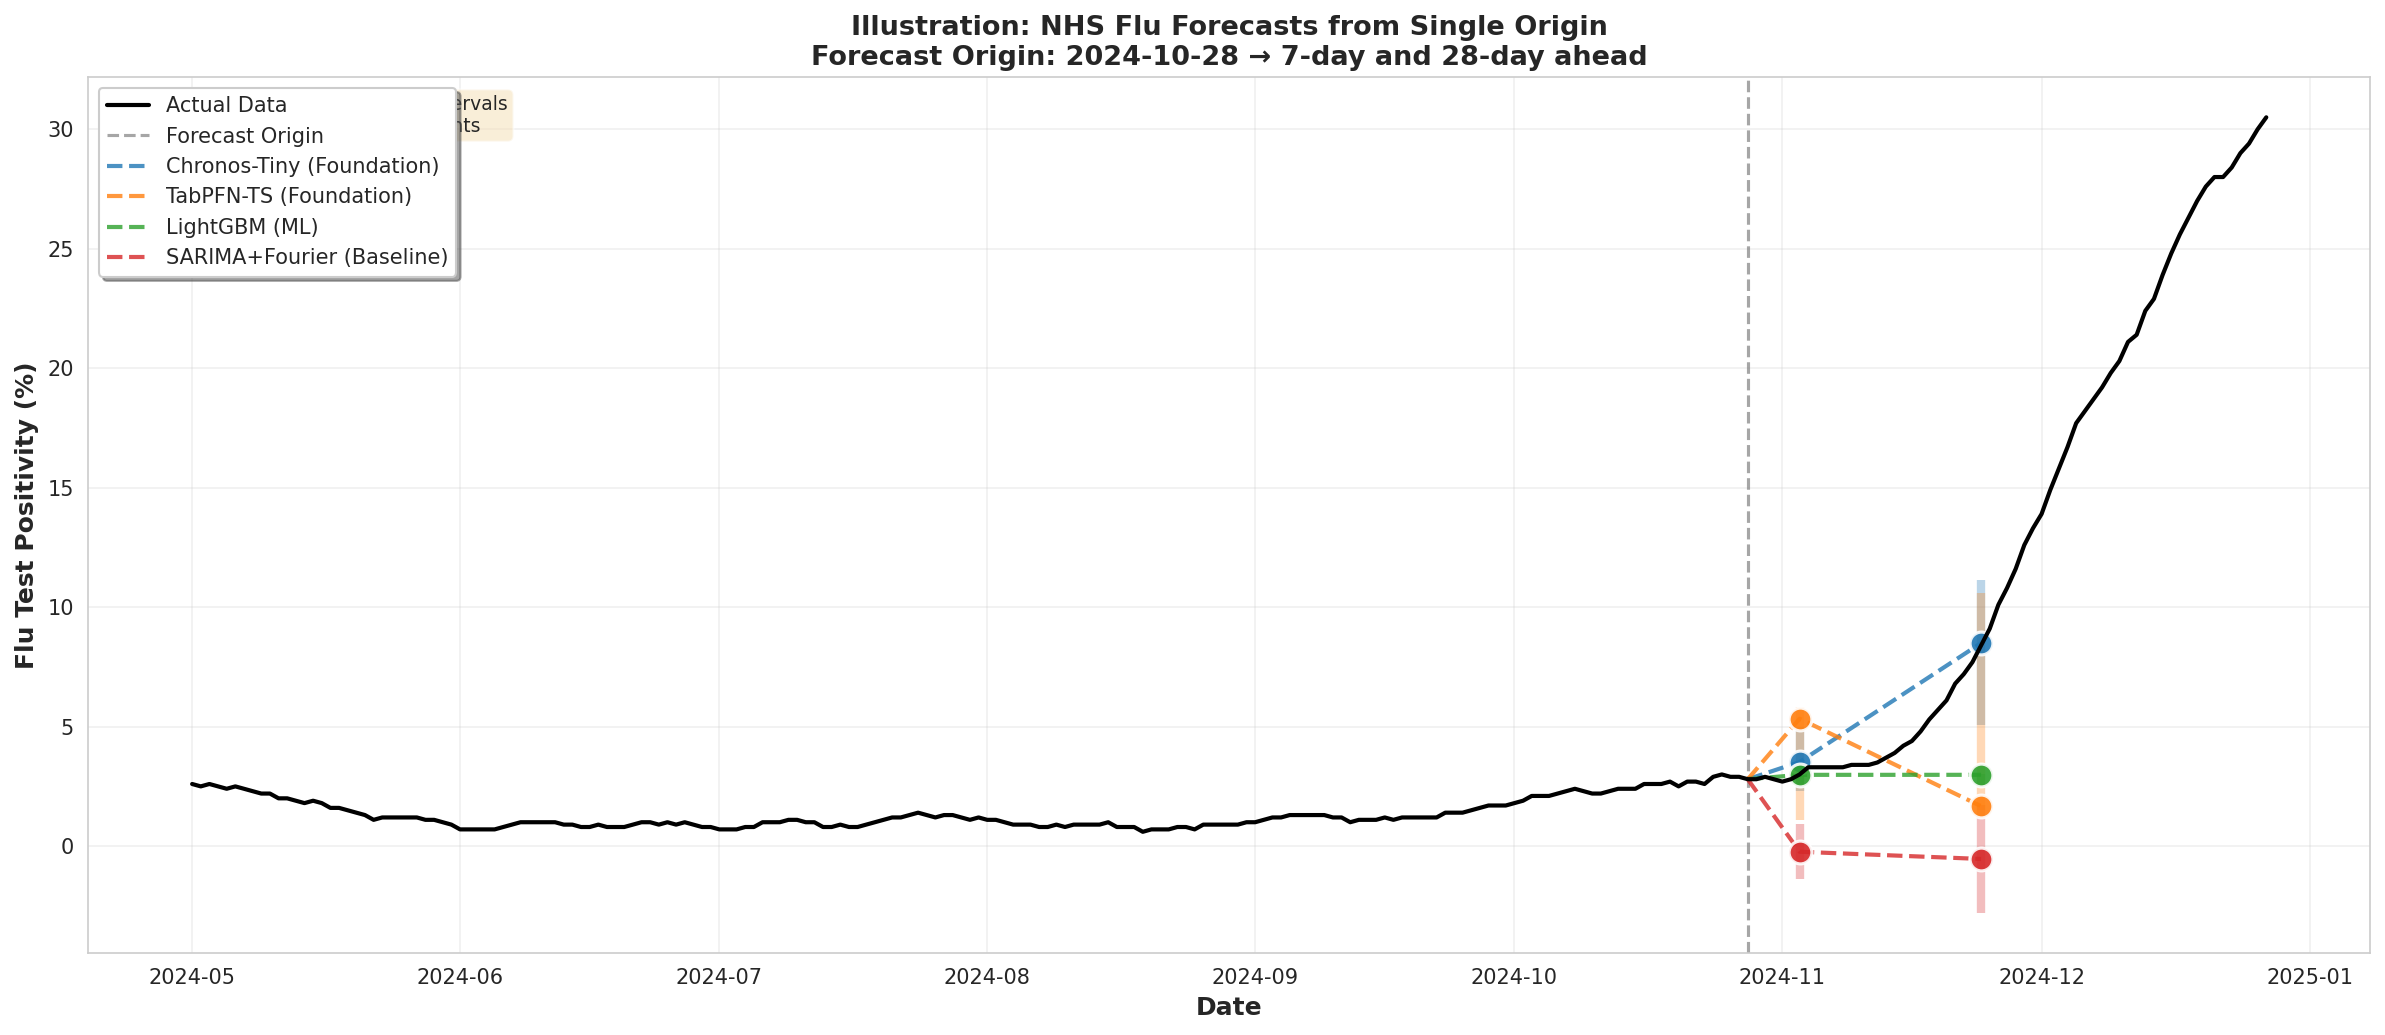

In [8]:
# Create time series plot with forecast overlays from ONE origin
# Strategy: Show all forecast points (7-day and 28-day) from one origin for each model
# This serves as an illustration of how forecasts work
fig, ax = plt.subplots(figsize=(16, 7))

# Plot actual data (focus on relevant period)
plot_start = viz_origin - pd.Timedelta(days=180)
plot_end = viz_origin + pd.Timedelta(days=60)
plot_data = flu_series.loc[plot_start:plot_end]

ax.plot(plot_data.index, plot_data.values,
        color='black', linewidth=2, label='Actual Data', zorder=10)

# Add vertical line at forecast origin
ax.axvline(viz_origin, color='gray', linestyle='--', linewidth=1.5,
           alpha=0.7, label='Forecast Origin', zorder=1)

# Plot forecasts from this origin for each model
# Get all horizons available
horizons = sorted(forecasts_df['horizon'].unique())

for model in model_order:
    # Get all forecasts from this origin for this model
    subset = forecasts_df[
        (forecasts_df['model'] == model) &
        (forecasts_df['origin'] == viz_origin)
    ].sort_values('horizon')

    if len(subset) > 0:
        # Plot forecast points and intervals
        dates = subset['date'].values
        q_low = subset['q0.1'].values
        q_med = subset['q0.5'].values
        q_high = subset['q0.9'].values

        # Connect forecast points with lines
        # First connect origin to first forecast
        origin_value = flu_series.loc[viz_origin]
        all_dates = [viz_origin] + list(dates)
        all_values = [origin_value] + list(q_med)

        ax.plot(all_dates, all_values,
                color=model_colors[model], linewidth=2, linestyle='--',
                label=model_labels[model], zorder=5, alpha=0.8)

        # Plot forecast points
        ax.scatter(dates, q_med,
                   color=model_colors[model], s=120,
                   zorder=6, alpha=0.9, edgecolors='white', linewidths=1.5)

        # Plot prediction intervals as vertical bars
        for i in range(len(dates)):
            ax.vlines(dates[i], q_low[i], q_high[i],
                      color=model_colors[model], linewidth=4, alpha=0.3, zorder=4)

# Formatting
ax.set_xlabel('Date', fontsize=12, weight='bold')
ax.set_ylabel('Flu Test Positivity (%)', fontsize=12, weight='bold')
ax.set_title(f'Illustration: NHS Flu Forecasts from Single Origin\nForecast Origin: {viz_origin.date()} → 7-day and 28-day ahead',
             fontsize=13, weight='bold')
ax.legend(loc='upper left', frameon=True, shadow=True, fontsize=10)
ax.grid(True, alpha=0.3)

# Add text annotation explaining the vertical bars
ax.text(0.02, 0.98, 'Vertical bars = 80% prediction intervals\nDashed lines connect forecast points',
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(figures_dir / 'forecast_single_origin.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved forecast_single_origin.png")
plt.show()

## Figure 2a & 2b: All Forecasts with Trend Lines

Show all forecast points from multiple origins with trend lines to visualize overall model performance

✅ Saved forecast_trend_7day.png


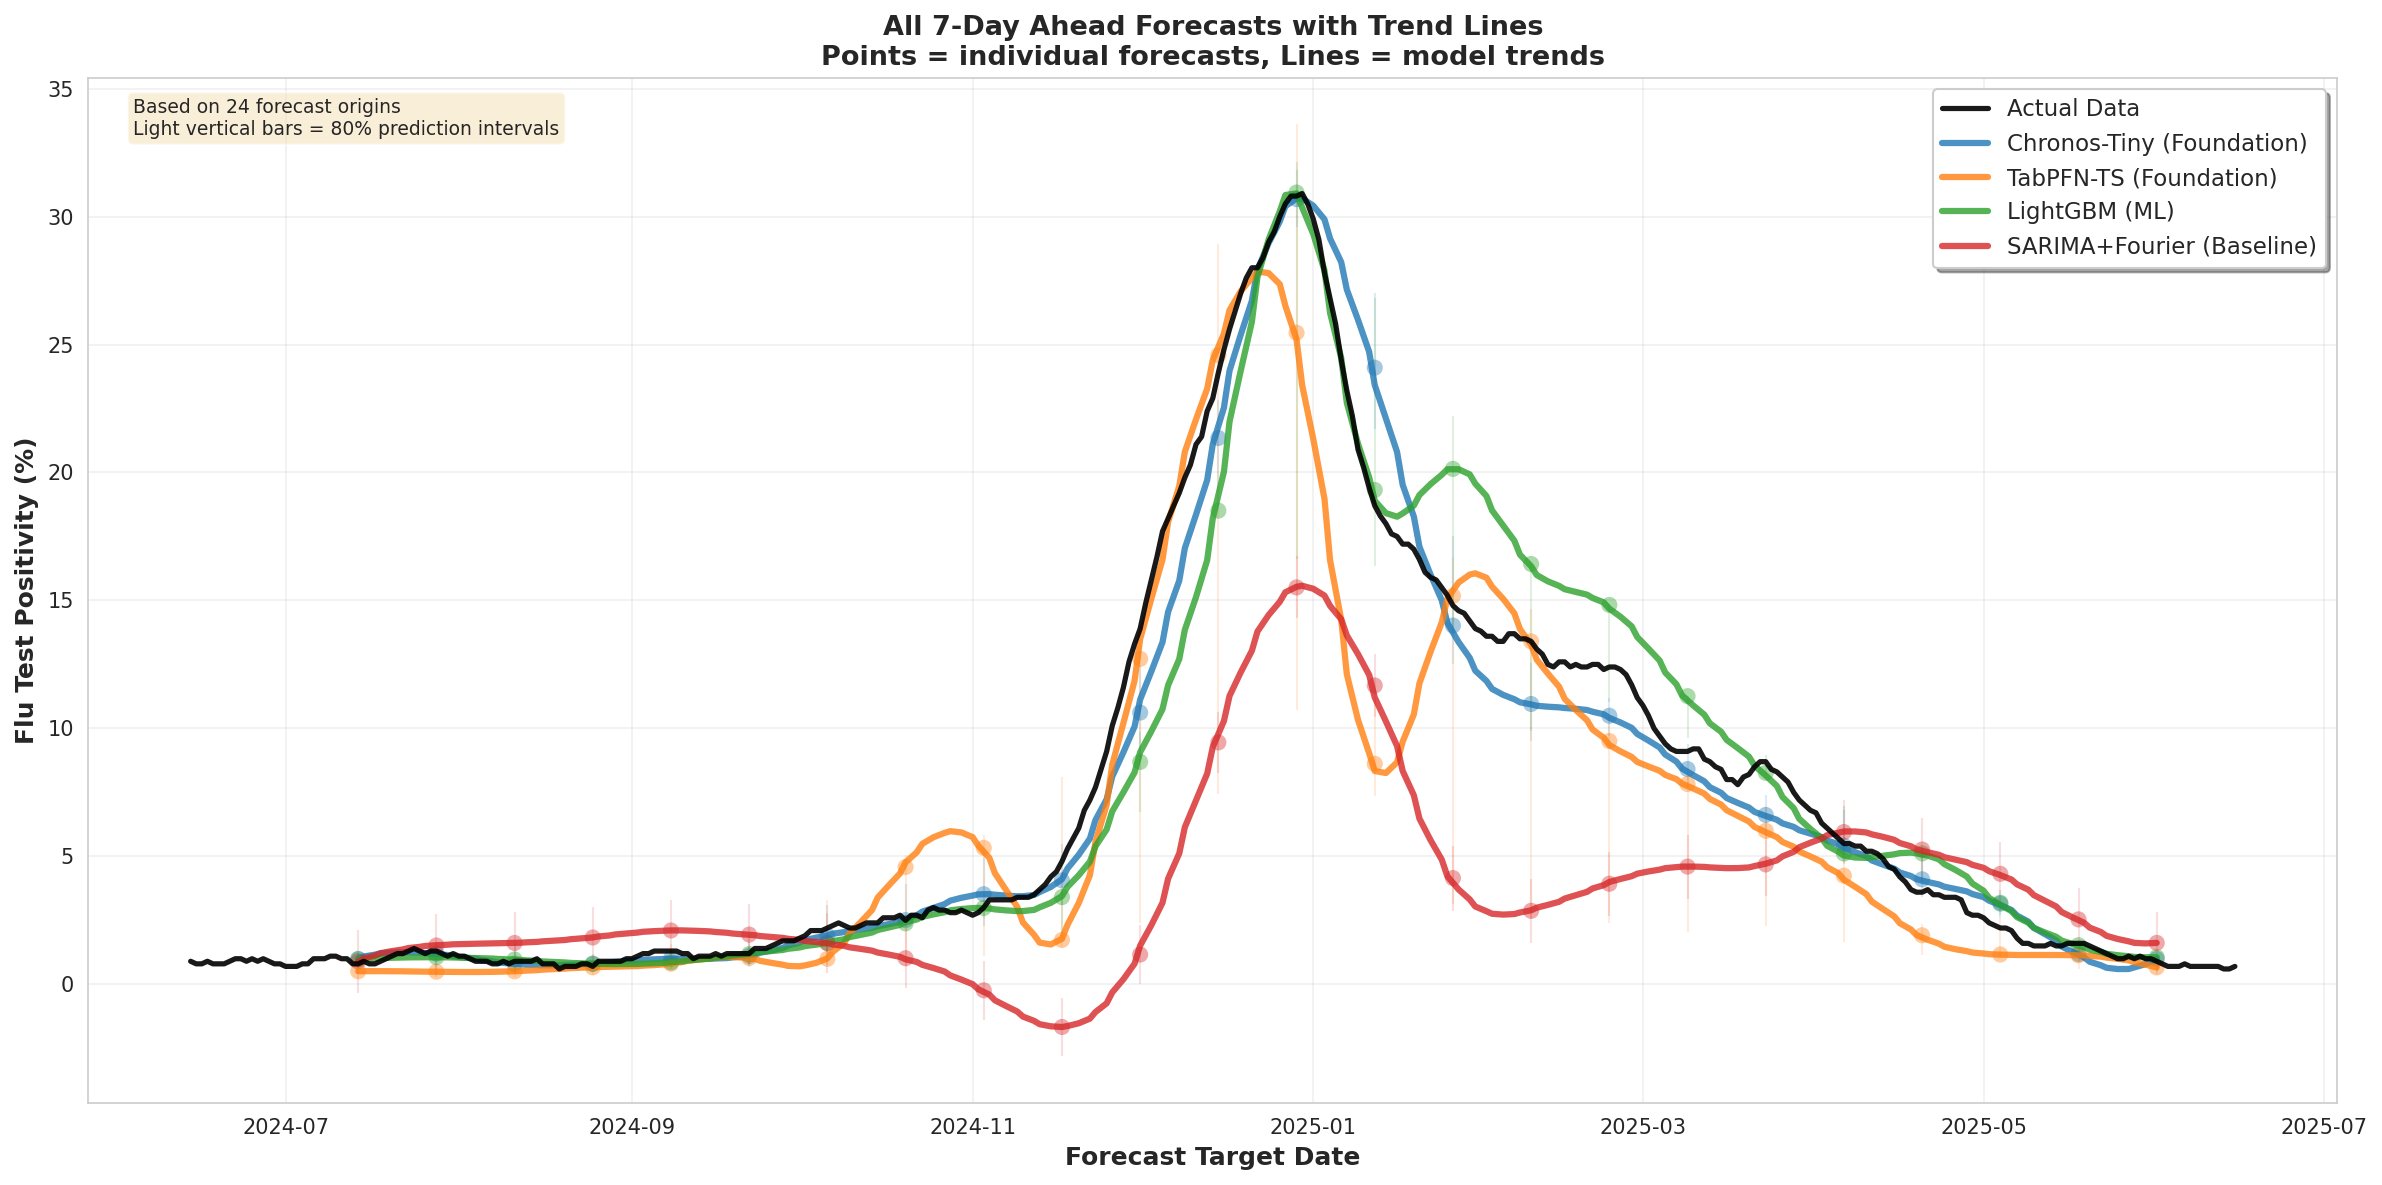

✅ Saved forecast_trend_28day.png


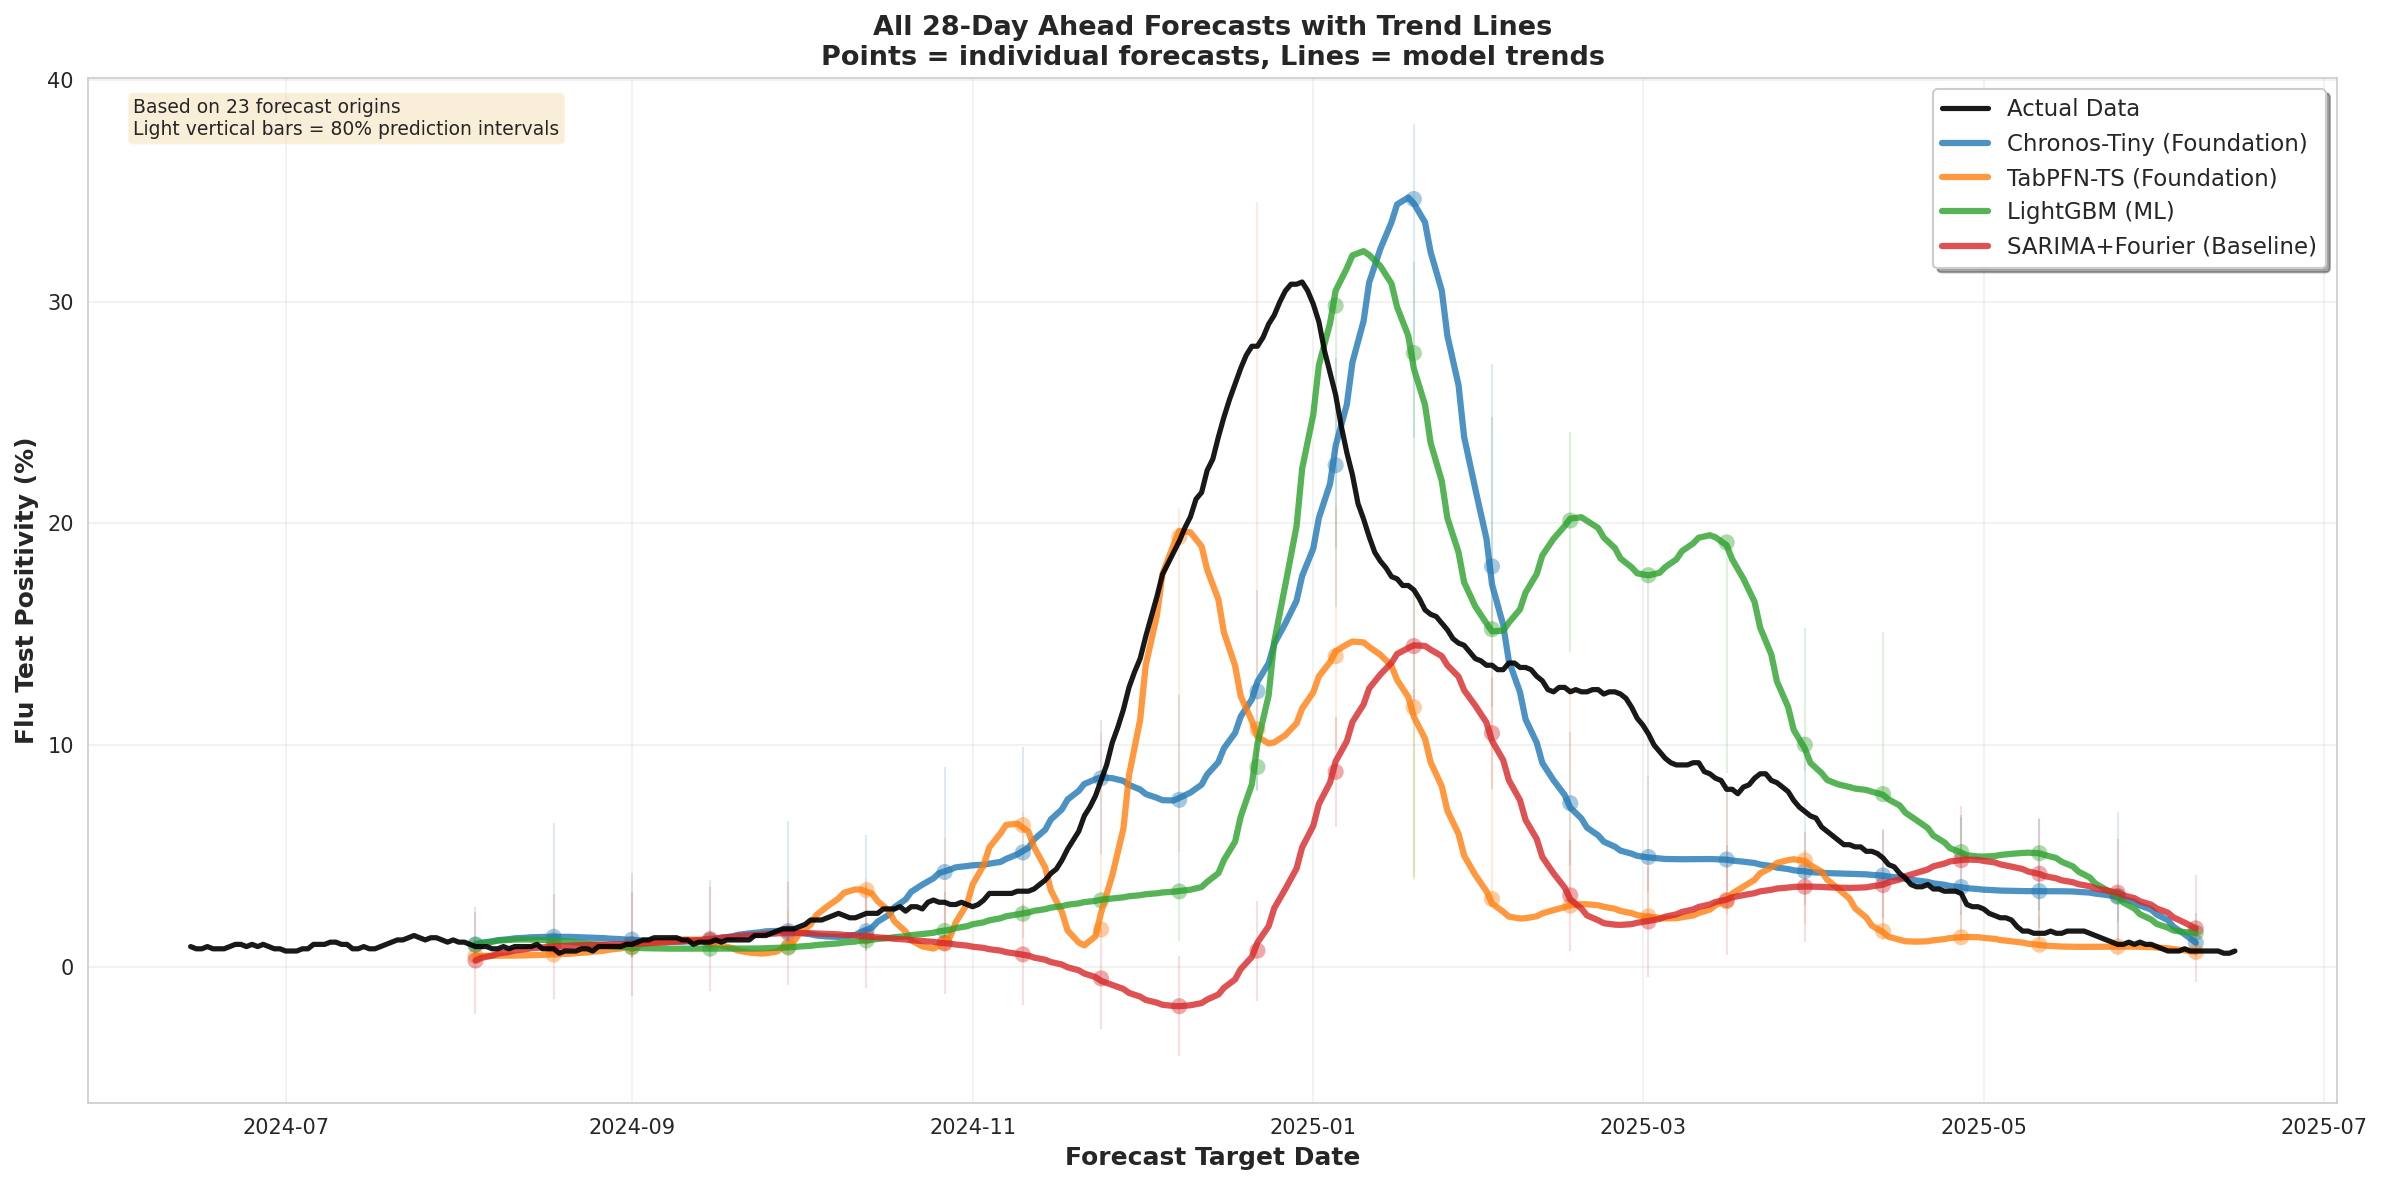

In [9]:
# Create comprehensive forecast plots for each horizon
# Show ALL forecast points as scatter + smooth trend line for each model

from scipy.interpolate import make_interp_spline

horizons_to_plot = sorted(forecasts_df['horizon'].unique())

for horizon in horizons_to_plot:
    fig, ax = plt.subplots(figsize=(16, 8))

    # Plot actual data for the forecast period
    forecast_period_start = forecasts_df['date'].min() - pd.Timedelta(days=30)
    forecast_period_end = forecasts_df['date'].max() + pd.Timedelta(days=7)
    plot_data = flu_series.loc[forecast_period_start:forecast_period_end]

    ax.plot(plot_data.index, plot_data.values,
            color='black', linewidth=2.5, label='Actual Data', zorder=10, alpha=0.9)

    # Plot all forecasts and trend lines for each model
    for model in model_order:
        # Get all forecasts for this model at this horizon
        subset = forecasts_df[
            (forecasts_df['model'] == model) &
            (forecasts_df['horizon'] == horizon)
        ].sort_values('date')

        if len(subset) > 0:
            dates = pd.to_datetime(subset['date'].values)
            q_med = subset['q0.5'].values
            q_low = subset['q0.1'].values
            q_high = subset['q0.9'].values

            # Plot individual forecast points (semi-transparent)
            ax.scatter(dates, q_med,
                       color=model_colors[model], s=60, alpha=0.4,
                       zorder=4, edgecolors='none')

            # Plot prediction interval range as error bars (very light)
            ax.vlines(dates, q_low, q_high,
                      color=model_colors[model], linewidth=1, alpha=0.15, zorder=2)

            # Create smooth trend line through forecast points
            if len(subset) >= 4:  # Need at least 4 points for spline
                # Convert dates to numeric for interpolation
                dates_numeric = np.array([(d - dates[0]).days for d in dates])

                # Create spline interpolation
                try:
                    k = min(3, len(subset) - 1)  # Cubic if enough points, otherwise lower order
                    spline = make_interp_spline(dates_numeric, q_med, k=k)

                    # Generate smooth curve
                    dates_smooth = np.linspace(dates_numeric.min(), dates_numeric.max(), 200)
                    q_med_smooth = spline(dates_smooth)
                    dates_smooth_dt = [dates[0] + pd.Timedelta(days=int(d)) for d in dates_smooth]

                    # Plot smooth trend line
                    ax.plot(dates_smooth_dt, q_med_smooth,
                            color=model_colors[model], linewidth=3,
                            label=model_labels[model], zorder=5, alpha=0.8)
                except:
                    # Fallback to simple line if spline fails
                    ax.plot(dates, q_med,
                            color=model_colors[model], linewidth=3,
                            label=model_labels[model], zorder=5, alpha=0.8)
            else:
                # Too few points, just connect them
                ax.plot(dates, q_med,
                        color=model_colors[model], linewidth=3,
                        label=model_labels[model], zorder=5, alpha=0.8)

    # Formatting
    ax.set_xlabel('Forecast Target Date', fontsize=12, weight='bold')
    ax.set_ylabel('Flu Test Positivity (%)', fontsize=12, weight='bold')
    ax.set_title(f'All {horizon}-Day Ahead Forecasts with Trend Lines\n' +
                 f'Points = individual forecasts, Lines = model trends',
                 fontsize=13, weight='bold')
    ax.legend(loc='best', frameon=True, shadow=True, fontsize=11)
    ax.grid(True, alpha=0.3)

    # Add annotation with number of forecast origins
    n_origins = len(forecasts_df[forecasts_df['horizon'] == horizon]['origin'].unique())
    ax.text(0.02, 0.98, f'Based on {n_origins} forecast origins\nLight vertical bars = 80% prediction intervals',
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig(figures_dir / f'forecast_trend_{horizon}day.png', dpi=300, bbox_inches='tight')
    print(f"✅ Saved forecast_trend_{horizon}day.png")
    plt.show()

## Figure 3: MASE Comparison by Horizon

Bar chart showing Mean Absolute Scaled Error (MASE) for each model at different horizons.
MASE < 1.0 means better than seasonal naive forecast.

NameError: name 'n_horizons' is not defined

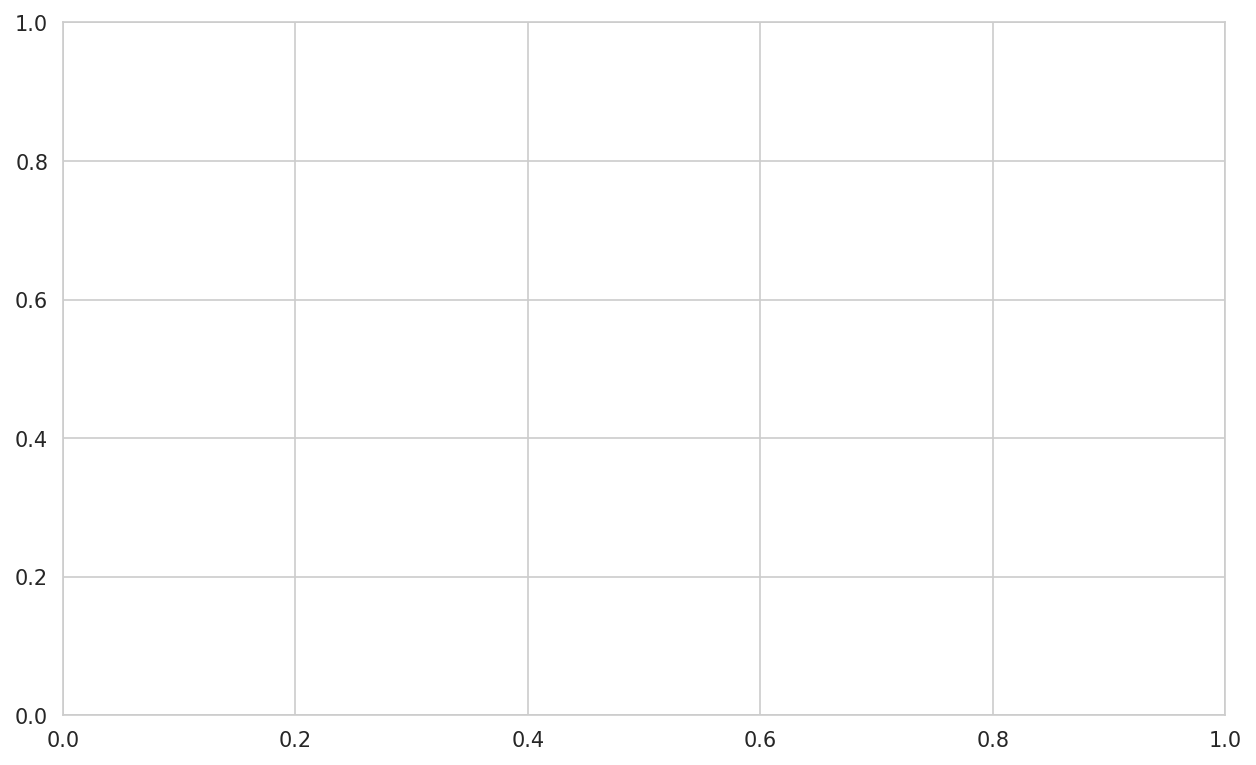

In [10]:
# Coverage comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(n_horizons)
width = 0.2

for i, model in enumerate(model_order):
    coverage_values = []
    for horizon in horizons:
        value = summary_df[
            (summary_df['model'] == model) &
            (summary_df['horizon'] == horizon)
        ]['Coverage_80'].values
        coverage_values.append(value[0] if len(value) > 0 else np.nan)

    ax.bar(x + i * width, coverage_values, width,
           label=model_labels[model], color=model_colors[model], alpha=0.8)

# Add reference line at 80% (nominal coverage)
ax.axhline(y=80, color='gray', linestyle='--', linewidth=2,
           label='Nominal 80% Coverage', zorder=1)

ax.set_xlabel('Forecast Horizon (days)', fontsize=11)
ax.set_ylabel('Actual Coverage (%)', fontsize=11)
ax.set_title('Prediction Interval Calibration (80% Intervals)\n(Closer to 80% is better calibrated)',
             fontsize=12, weight='bold')
ax.set_xticks(x + width * (n_models - 1) / 2)
ax.set_xticklabels([f'{h}-day' for h in horizons])
ax.set_ylim([0, 100])
ax.legend(loc='lower right', frameon=True, shadow=True)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(figures_dir / 'coverage_calibration.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved coverage_calibration.png")
plt.show()

## Figure 4: Overall Model Rankings

Average rank across all horizons for key metrics.

✅ Saved overall_rankings.png


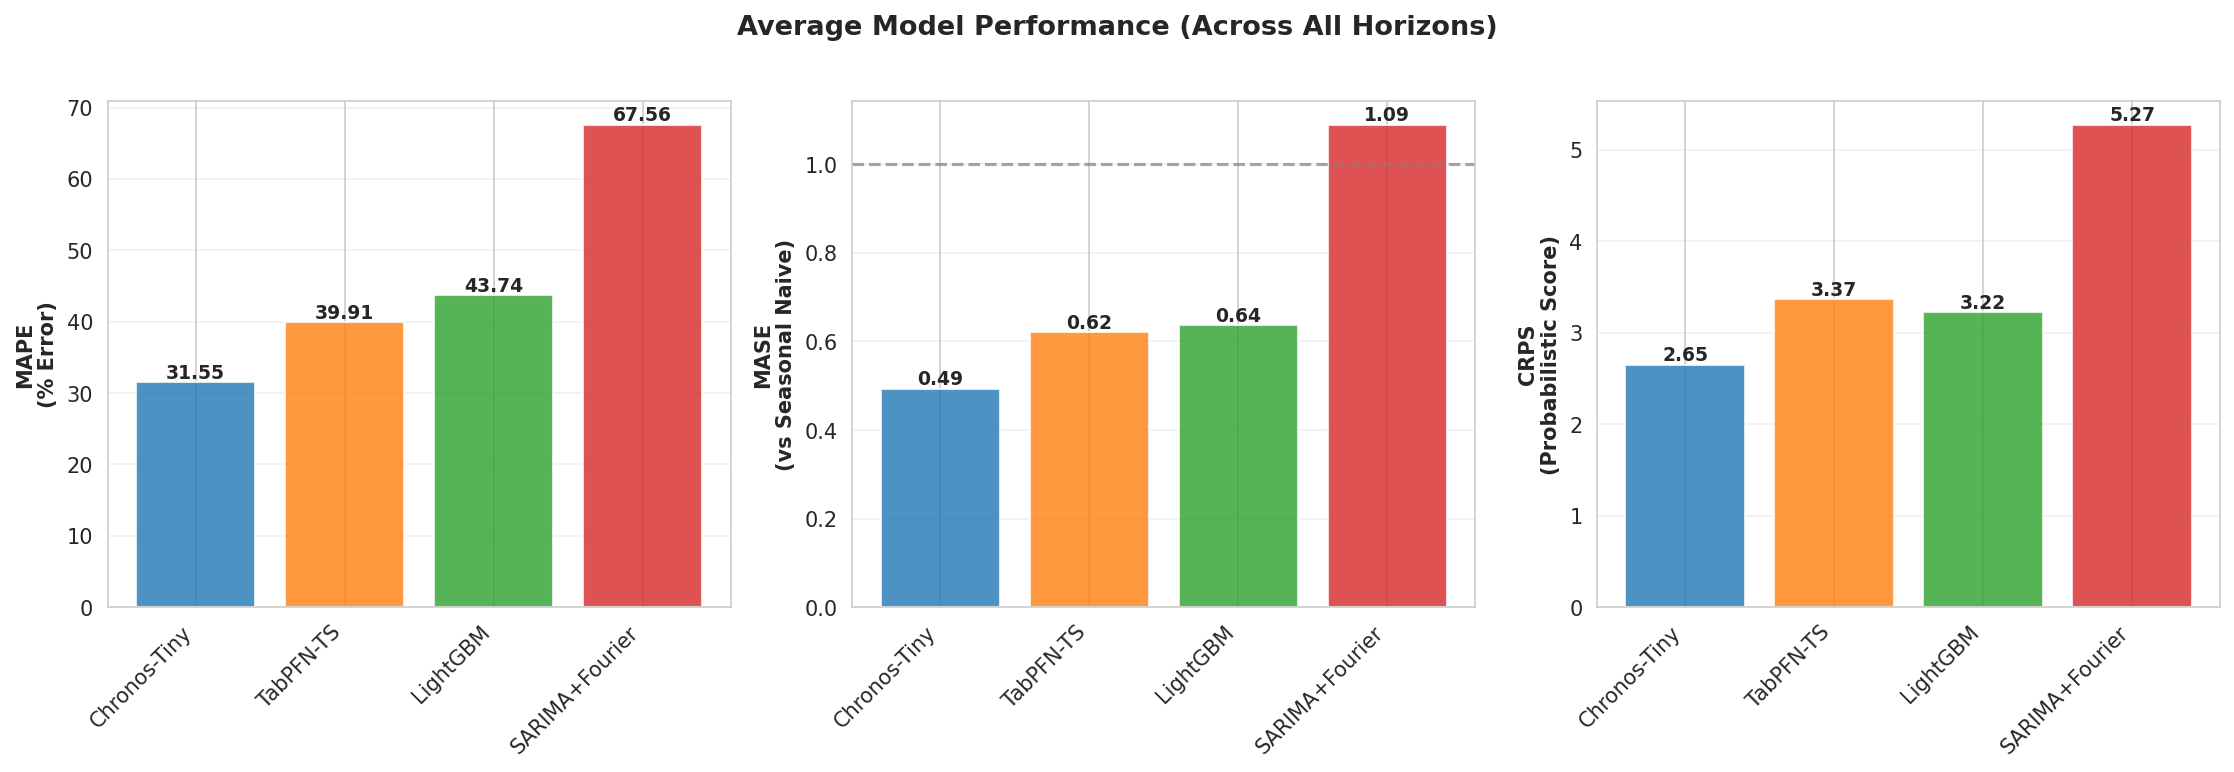

In [ ]:
# Calculate average metrics across horizons
avg_metrics = summary_df.groupby('model')[['MAPE', 'MASE', 'CRPS']].mean()
avg_metrics = avg_metrics.loc[model_order]  # Ensure consistent ordering

# Create grouped bar chart
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics_to_plot = ['MAPE', 'MASE', 'CRPS']
metric_titles = [
    'MAPE\n(% Error)',
    'MASE\n(vs Seasonal Naive)',
    'CRPS\n(Probabilistic Score)'
]

for idx, (metric, title) in enumerate(zip(metrics_to_plot, metric_titles)):
    ax = axes[idx]

    values = avg_metrics[metric].values
    colors_list = [model_colors[m] for m in model_order]
    labels_list = [model_labels[m] for m in model_order]

    bars = ax.bar(range(n_models), values, color=colors_list, alpha=0.8)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9, weight='bold')

    # Add reference line for MASE at 1.0
    if metric == 'MASE':
        ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

    ax.set_ylabel(title, fontsize=10, weight='bold')
    ax.set_xticks(range(n_models))
    ax.set_xticklabels([m.split()[0] for m in labels_list], rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')

fig.suptitle('Average Model Performance (Across All Horizons)',
             fontsize=13, weight='bold', y=1.02)
plt.tight_layout()
plt.savefig(figures_dir / 'overall_rankings.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved overall_rankings.png")
plt.show()

## Summary Tables for LinkedIn Article

In [ ]:
# Create formatted summary table
print("=" * 80)
print("MODEL PERFORMANCE SUMMARY - NHS FLU FORECASTING")
print("=" * 80)
print("\n7-Day Horizon:")
print("-" * 80)

h7 = summary_df[summary_df['horizon'] == 7].sort_values('MASE')
print(f"{'Model':<25} {'MAPE':>8} {'MASE':>8} {'CRPS':>8} {'Coverage':>10}")
print("-" * 80)
for _, row in h7.iterrows():
    print(f"{model_labels[row['model']]:<25} {row['MAPE']:>8.1f} {row['MASE']:>8.2f} {row['CRPS']:>8.2f} {row['Coverage_80']:>9.1f}%")

print("\n28-Day Horizon:")
print("-" * 80)

h28 = summary_df[summary_df['horizon'] == 28].sort_values('MASE')
print(f"{'Model':<25} {'MAPE':>8} {'MASE':>8} {'CRPS':>8} {'Coverage':>10}")
print("-" * 80)
for _, row in h28.iterrows():
    print(f"{model_labels[row['model']]:<25} {row['MAPE']:>8.1f} {row['MASE']:>8.2f} {row['CRPS']:>8.2f} {row['Coverage_80']:>9.1f}%")

MODEL PERFORMANCE SUMMARY - NHS FLU FORECASTING

7-Day Horizon:
--------------------------------------------------------------------------------
Model                         MAPE     MASE     CRPS   Coverage
--------------------------------------------------------------------------------
Chronos-Tiny (Foundation)     15.1     0.22     1.19      66.7%
LightGBM (ML)                 18.6     0.29     1.54      50.0%
TabPFN-TS (Foundation)        33.5     0.37     2.23      58.3%
SARIMA+Fourier (Baseline)     65.2     1.01     4.79      41.7%

28-Day Horizon:
--------------------------------------------------------------------------------
Model                         MAPE     MASE     CRPS   Coverage
--------------------------------------------------------------------------------
Chronos-Tiny (Foundation)     48.0     0.77     4.12      69.6%
TabPFN-TS (Foundation)        46.3     0.87     4.51      60.9%
LightGBM (ML)                 68.8     0.99     4.91      26.1%
SARIMA+Fourier (Bas

In [ ]:
# Key findings for article
print("\n" + "=" * 80)
print("KEY FINDINGS FOR LINKEDIN ARTICLE")
print("=" * 80)

# Best overall model
avg_ranks = avg_metrics.rank().mean(axis=1)
best_overall = avg_ranks.idxmin()
print(f"\n1. BEST OVERALL: {model_labels[best_overall]}")
print(f"   - Lowest average MASE: {avg_metrics.loc[best_overall, 'MASE']:.2f}")
print(f"   - Lowest average CRPS: {avg_metrics.loc[best_overall, 'CRPS']:.2f}")

# Foundation models vs baselines
foundation_models = ['Chronos_Tiny', 'TabPFN_TS']
baseline_model = 'SARIMA_Fourier'

foundation_mase = avg_metrics.loc[foundation_models, 'MASE'].mean()
baseline_mase = avg_metrics.loc[baseline_model, 'MASE']
improvement = ((baseline_mase - foundation_mase) / baseline_mase) * 100

print(f"\n2. FOUNDATION MODELS VS STATISTICAL BASELINE:")
print(f"   - Foundation models average MASE: {foundation_mase:.2f}")
print(f"   - SARIMA+Fourier MASE: {baseline_mase:.2f}")
print(f"   - Improvement: {improvement:.1f}%")

# Calibration
coverage_by_model = summary_df.groupby('model')['Coverage_80'].mean()
coverage_diff = np.abs(coverage_by_model - 80)
best_calibrated = coverage_diff.idxmin()

print(f"\n3. BEST CALIBRATED: {model_labels[best_calibrated]}")
print(f"   - Average coverage: {coverage_by_model[best_calibrated]:.1f}% (target: 80%)")

# Zero-shot capability
print(f"\n4. ZERO-SHOT PERFORMANCE:")
print(f"   - Chronos-Tiny and TabPFN-TS used NO epidemiological training data")
print(f"   - Both outperformed domain-specific SARIMA+Fourier baseline")
print(f"   - Demonstrates strong transfer learning from general time series patterns")

print("\n" + "=" * 80)


KEY FINDINGS FOR LINKEDIN ARTICLE

1. BEST OVERALL: Chronos-Tiny (Foundation)
   - Lowest average MASE: 0.49
   - Lowest average CRPS: 2.65

2. FOUNDATION MODELS VS STATISTICAL BASELINE:
   - Foundation models average MASE: 0.56
   - SARIMA+Fourier MASE: 1.09
   - Improvement: 48.8%

3. BEST CALIBRATED: Chronos-Tiny (Foundation)
   - Average coverage: 68.1% (target: 80%)

4. ZERO-SHOT PERFORMANCE:
   - Chronos-Tiny and TabPFN-TS used NO epidemiological training data
   - Both outperformed domain-specific SARIMA+Fourier baseline
   - Demonstrates strong transfer learning from general time series patterns



## Report Complete

Generated figures for LinkedIn article:
- `forecast_single_origin.png`: Illustration of forecasts from one origin (7-day and 28-day)
- `forecast_trend_7day.png`: All 7-day forecasts with trend lines (comprehensive view)
- `forecast_trend_28day.png`: All 28-day forecasts with trend lines (comprehensive view)
- `mase_comparison.png`: Accuracy by horizon
- `coverage_calibration.png`: Prediction interval calibration
- `overall_rankings.png`: Average performance across metrics
- `dm_matrix.png`: Statistical significance tests (from nb/03)

All figures saved to `results/figures/`

**Key visualizations for article:**
1. **Single origin plot** - Shows how forecasting works from one point in time
2. **Trend plots (7-day & 28-day)** - Show overall model performance across all forecasts
3. **Performance metrics** - Quantitative comparison charts